In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import os


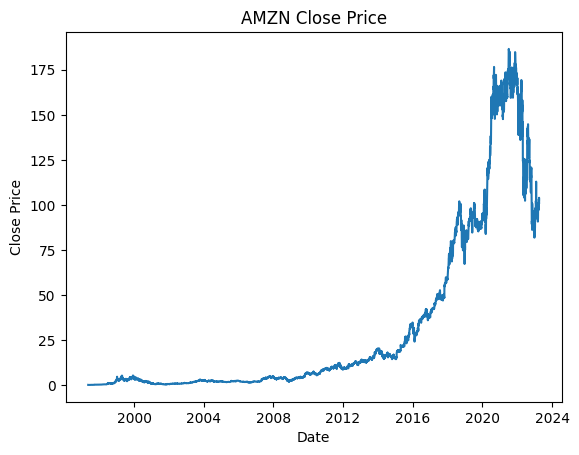

In [9]:


# Load and prepare data
data = pd.read_csv("AMZN.csv")[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])

# Plot original data
plt.plot(data['Date'], data['Close'])
plt.title("AMZN Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()



In [10]:

# Create lag features
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shift_df = prepare_dataframe_for_lstm(data, lookback)

# Save this for XGBoost use later (before scaling or reshaping)
shift_df.to_csv("shift_df_for_xgboost.csv")


In [11]:


# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
shift_df_np = scaler.fit_transform(shift_df.values)

# Separate features and labels
X = shift_df_np[:, 1:]
Y = shift_df_np[:, 0]

# Reverse column order for LSTM input
X = np.flip(X, axis=1)


In [12]:
# Train-test split
split_index = int(len(X) * 0.95)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

# Reshape for LSTM
# Make sure to call .copy() after reshaping if the original arrays
# could have negative strides, or simply before converting to tensor
X_train = X_train.reshape((-1, lookback, 1)).copy()
X_test = X_test.reshape((-1, lookback, 1)).copy()
Y_train = Y_train.reshape((-1, 1)).copy()
Y_test = Y_test.reshape((-1, 1)).copy()

# Convert to tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

In [13]:


# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:


# LSTM Model Definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(2, batch_size, 32).to(device)
        c0 = torch.zeros(2, batch_size, 32).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Instantiate model
model = LSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1).to(device)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:


# Training loop
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Train Loss: {running_loss / len(train_loader):.4f}")

def validate_one_epoch():
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    print(f"Val Loss: {running_loss / len(test_loader):.4f}\n")



In [16]:

# Train model
epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_one_epoch()
    validate_one_epoch()


Epoch 1/50
Train Loss: 0.0413
Val Loss: 0.0060

Epoch 2/50
Train Loss: 0.0004
Val Loss: 0.0053

Epoch 3/50
Train Loss: 0.0004
Val Loss: 0.0059

Epoch 4/50
Train Loss: 0.0003
Val Loss: 0.0065

Epoch 5/50
Train Loss: 0.0004
Val Loss: 0.0062

Epoch 6/50
Train Loss: 0.0004
Val Loss: 0.0050

Epoch 7/50
Train Loss: 0.0003
Val Loss: 0.0045

Epoch 8/50
Train Loss: 0.0004
Val Loss: 0.0048

Epoch 9/50
Train Loss: 0.0003
Val Loss: 0.0041

Epoch 10/50
Train Loss: 0.0003
Val Loss: 0.0046

Epoch 11/50
Train Loss: 0.0003
Val Loss: 0.0046

Epoch 12/50
Train Loss: 0.0003
Val Loss: 0.0037

Epoch 13/50
Train Loss: 0.0003
Val Loss: 0.0049

Epoch 14/50
Train Loss: 0.0003
Val Loss: 0.0042

Epoch 15/50
Train Loss: 0.0003
Val Loss: 0.0041

Epoch 16/50
Train Loss: 0.0003
Val Loss: 0.0035

Epoch 17/50
Train Loss: 0.0002
Val Loss: 0.0041

Epoch 18/50
Train Loss: 0.0003
Val Loss: 0.0033

Epoch 19/50
Train Loss: 0.0002
Val Loss: 0.0028

Epoch 20/50
Train Loss: 0.0002
Val Loss: 0.0026

Epoch 21/50
Train Loss: 0.000

In [17]:


# De-normalization function
def inverse_transform_column(pred, scaler, lookback):
    dummy = np.zeros((len(pred), lookback + 1))
    dummy[:, 0] = pred
    return scaler.inverse_transform(dummy)[:, 0]

# Train predictions
train_pred = model(X_train.to(device)).detach().cpu().numpy().flatten()
train_pred = inverse_transform_column(train_pred, scaler, lookback)
actual_train = inverse_transform_column(Y_train.numpy().flatten(), scaler, lookback)

# Test predictions
test_pred = model(X_test.to(device)).detach().cpu().numpy().flatten()
test_pred = inverse_transform_column(test_pred, scaler, lookback)
actual_test = inverse_transform_column(Y_test.numpy().flatten(), scaler, lookback)



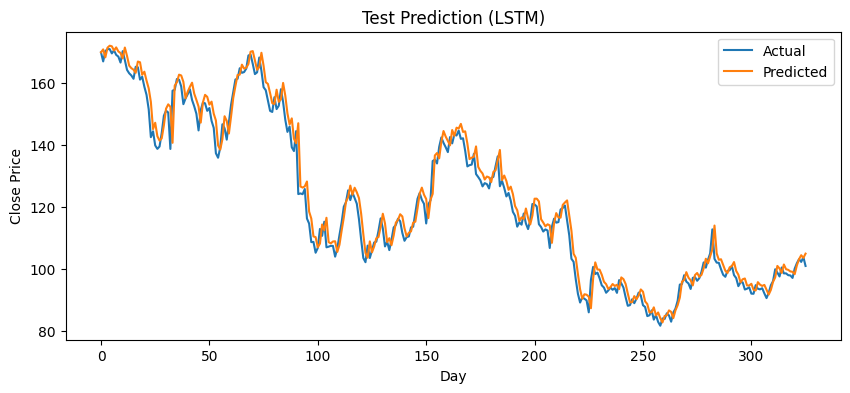

In [18]:

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(actual_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.title("Test Prediction (LSTM)")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.legend()
plt.show()




In [19]:

# Save LSTM model
torch.save(model.state_dict(), 'lstm_model.pth')
print("Model saved.")


Model saved.


In [20]:


# Export X and Y for XGBoost
# Use the raw (unscaled) `shift_df` that we saved earlier
shift_df = pd.read_csv("shift_df_for_xgboost.csv", index_col=0)
X_xgb = shift_df.iloc[:, 1:].values
Y_xgb = shift_df.iloc[:, 0].values

split_index = int(len(X_xgb) * 0.95)
X_train_xgb = X_xgb[:split_index]
X_test_xgb = X_xgb[split_index:]
Y_train_xgb = Y_xgb[:split_index]
Y_test_xgb = Y_xgb[split_index:]

np.save("X_train_xgb.npy", X_train_xgb)
np.save("X_test_xgb.npy", X_test_xgb)
np.save("Y_train_xgb.npy", Y_train_xgb)
np.save("Y_test_xgb.npy", Y_test_xgb)
